# Explicación se la selecion de variables de la Fase 2

Para entender cómo se clasifica cada repetición de los gestos como correcta o incorrecta, se generarán gráficos que visualicen la importancia de las variables seleccionadas y cómo estas son utilizadas por el modelo.

***- Importar librerías***

In [34]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import tree # visualizar dtree
# Suprimir warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

***- Importar datos***

In [35]:
df = pd.read_csv('../Resultados/medidasPerRepetition.csv', dtype=object)
df = df.apply(pd.to_numeric, errors='ignore')
df.loc[df['CorrectLabel'] == 3, 'CorrectLabel'] = 2

***- Gráficas***

Variables seleccionadas para el gesto EFL


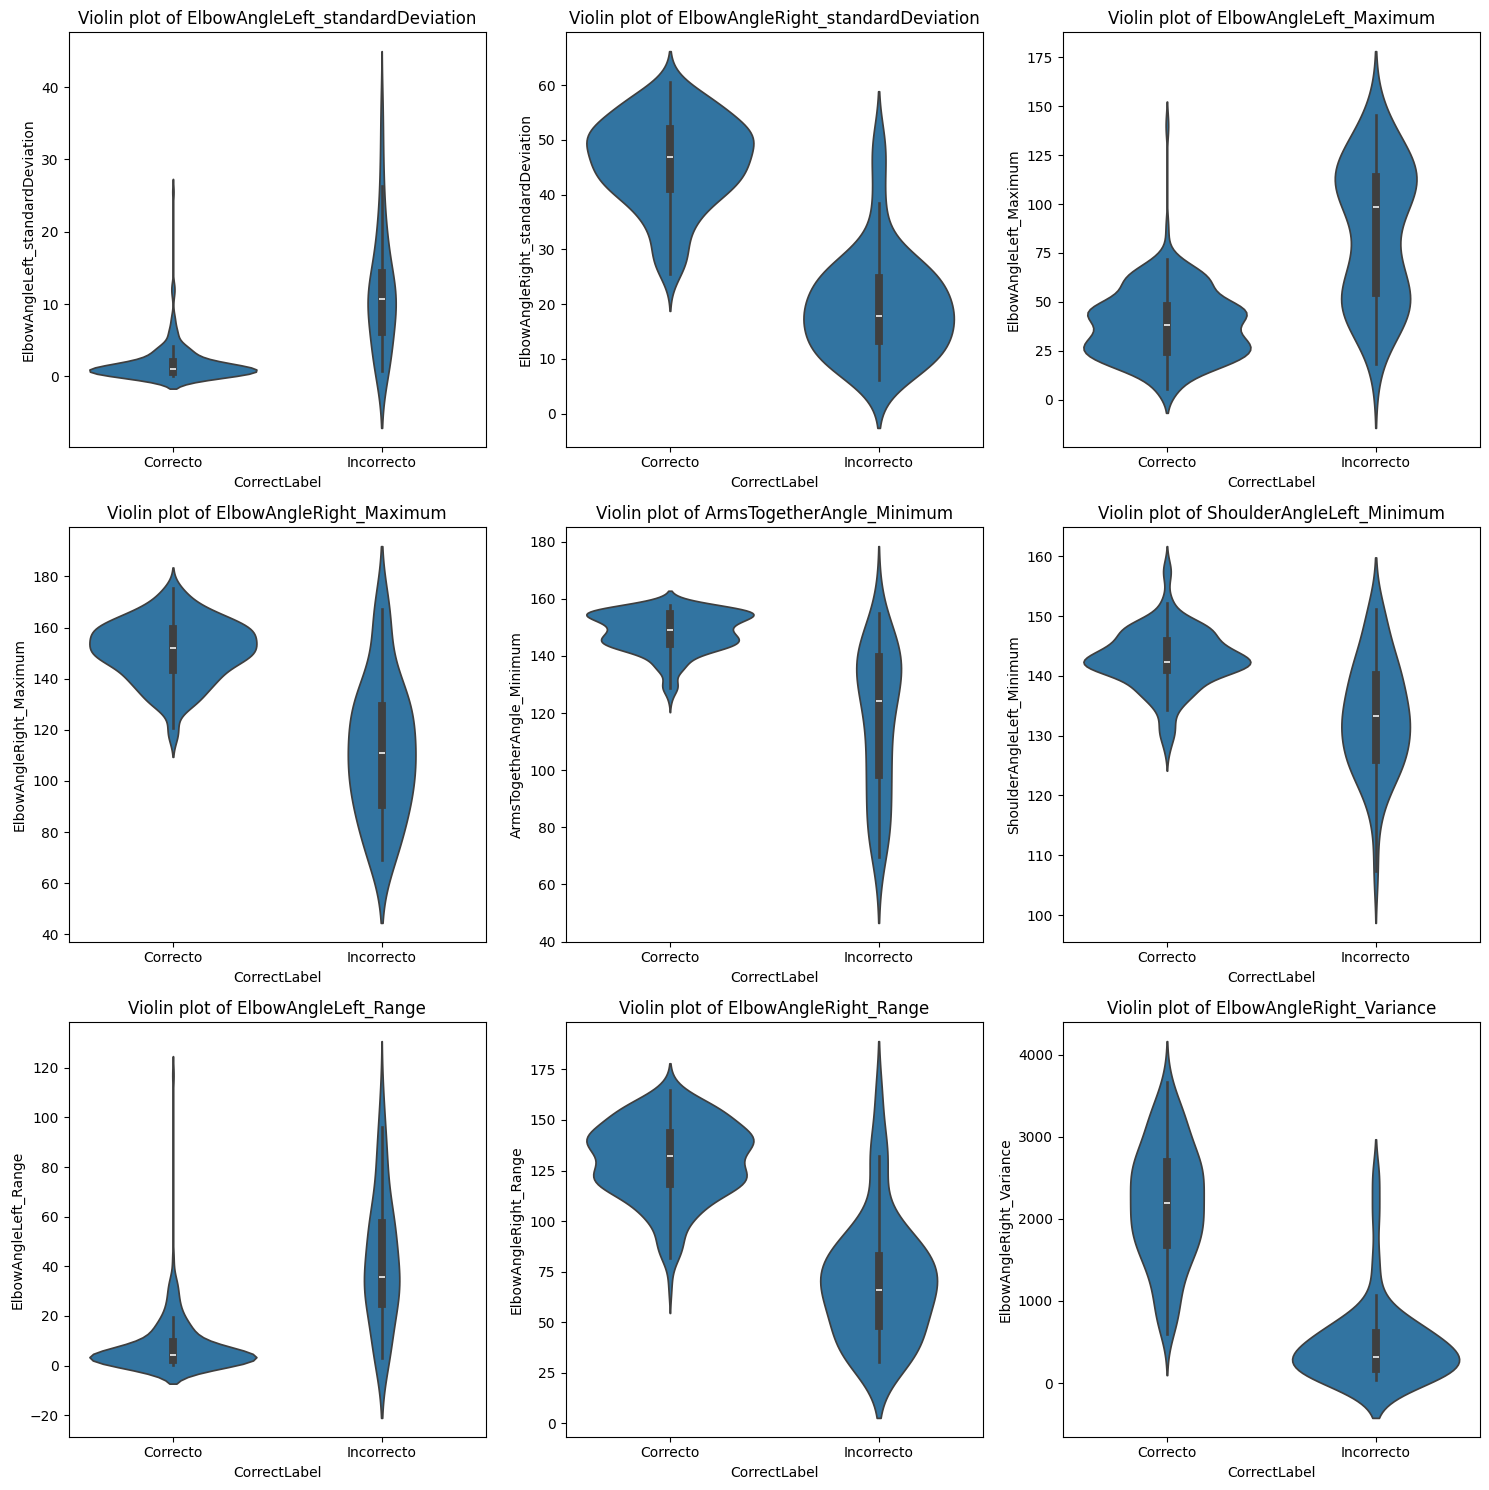

Se ha usado un GaussianNB


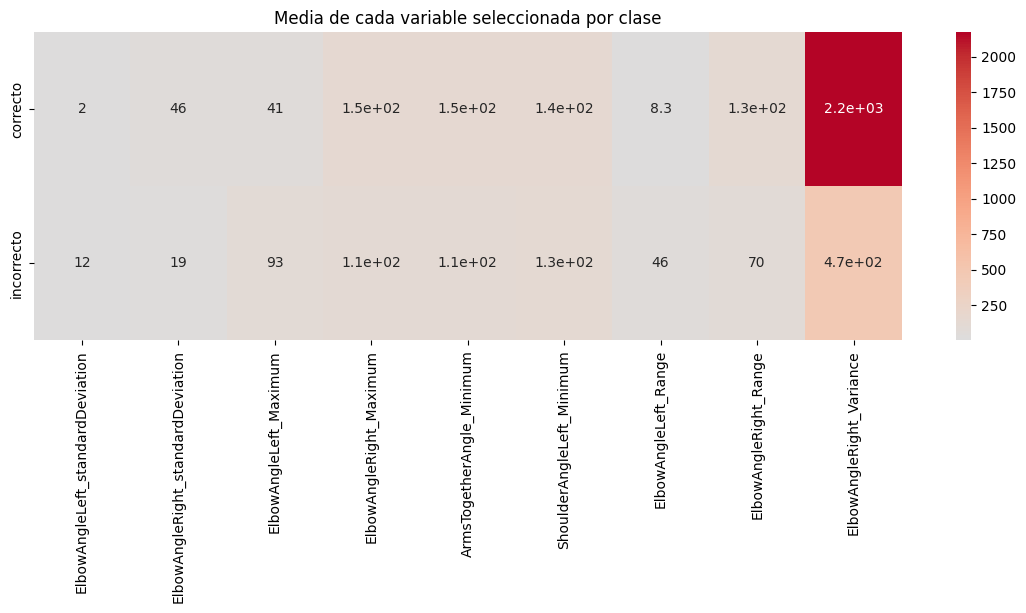

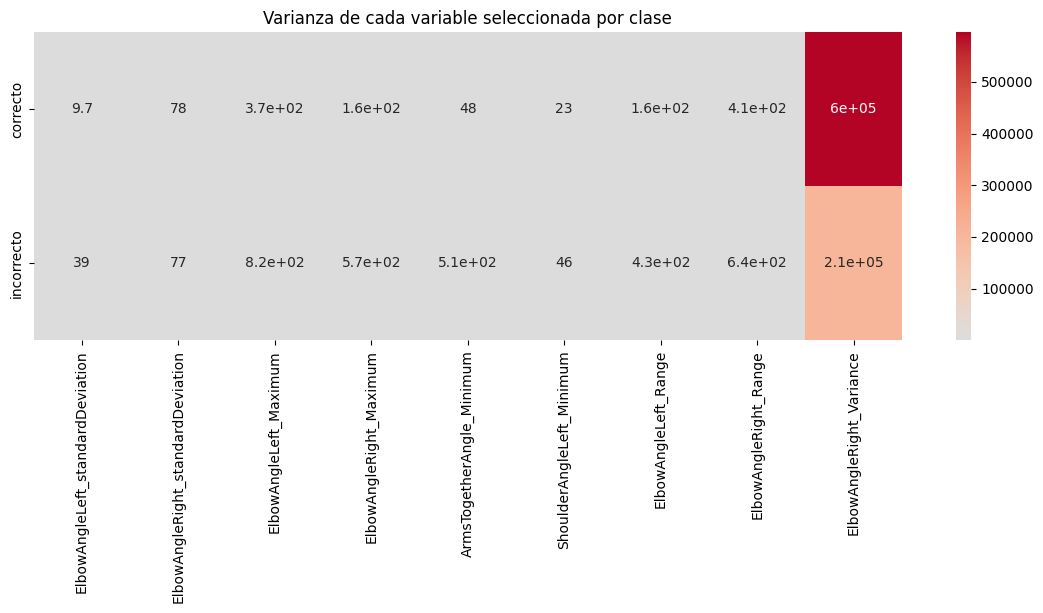

Variables seleccionadas para el gesto EFR


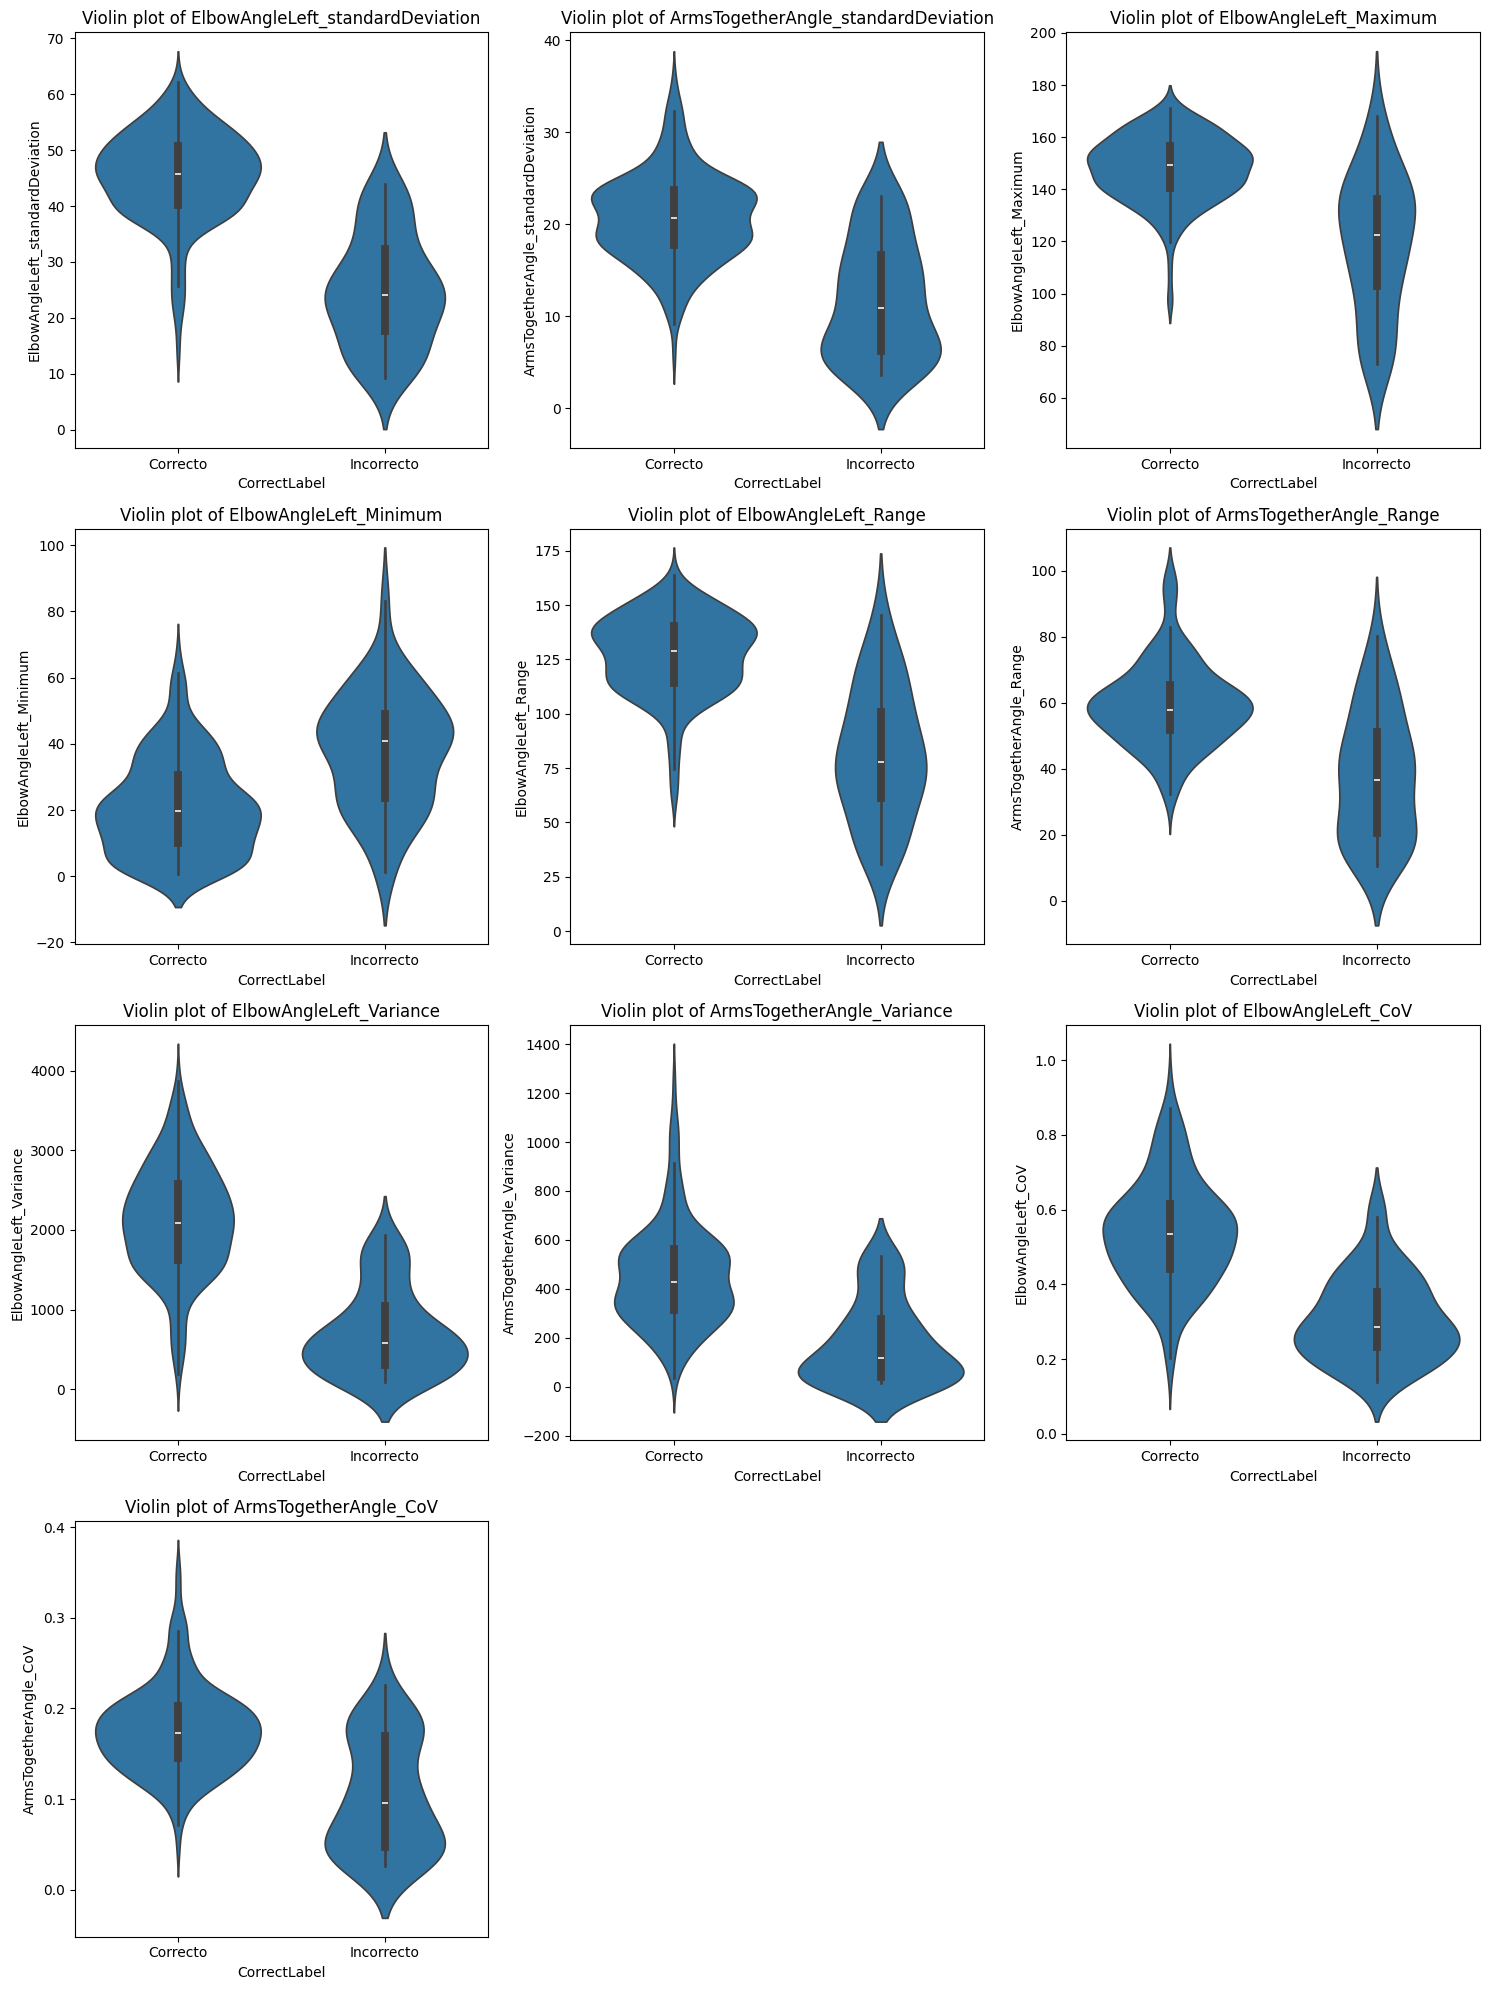

Se ha usado un LogisticRegression


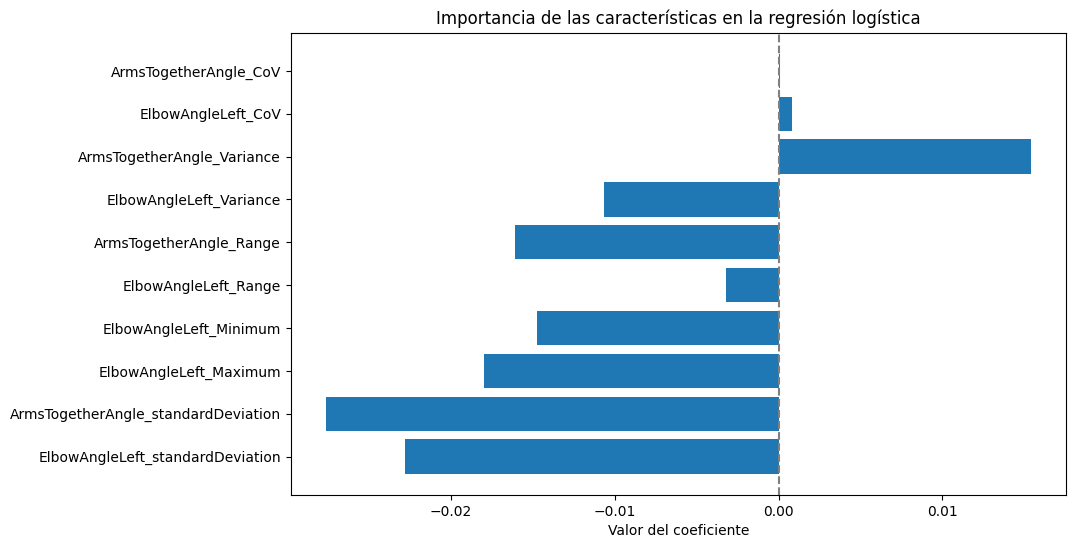

Variables seleccionadas para el gesto SFL


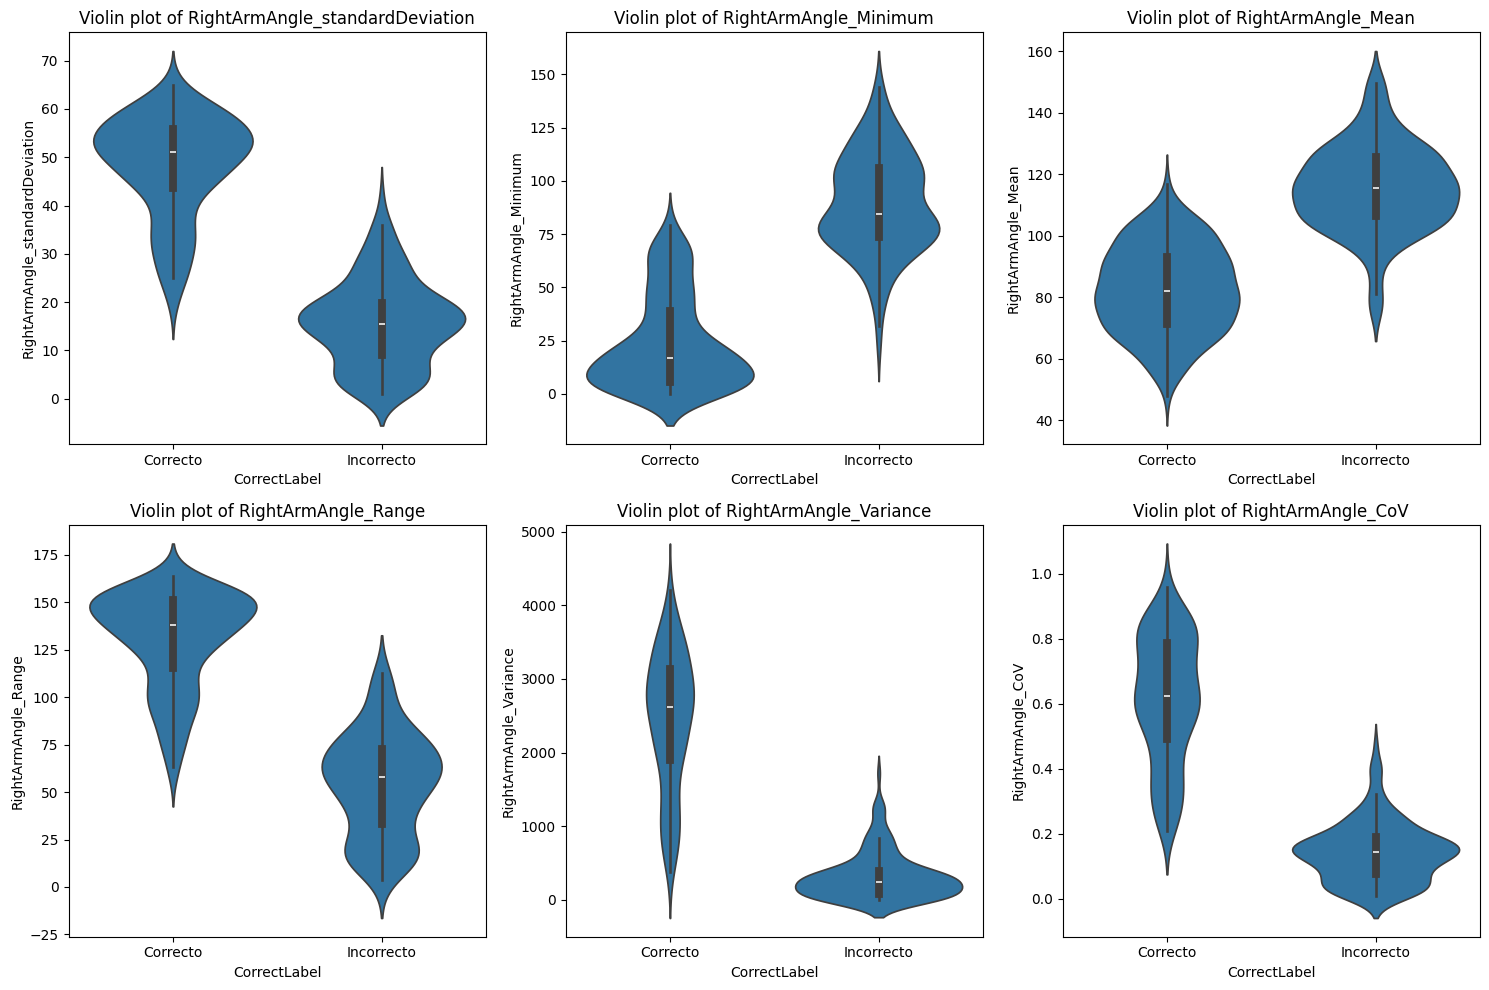

Se ha usado un GaussianNB


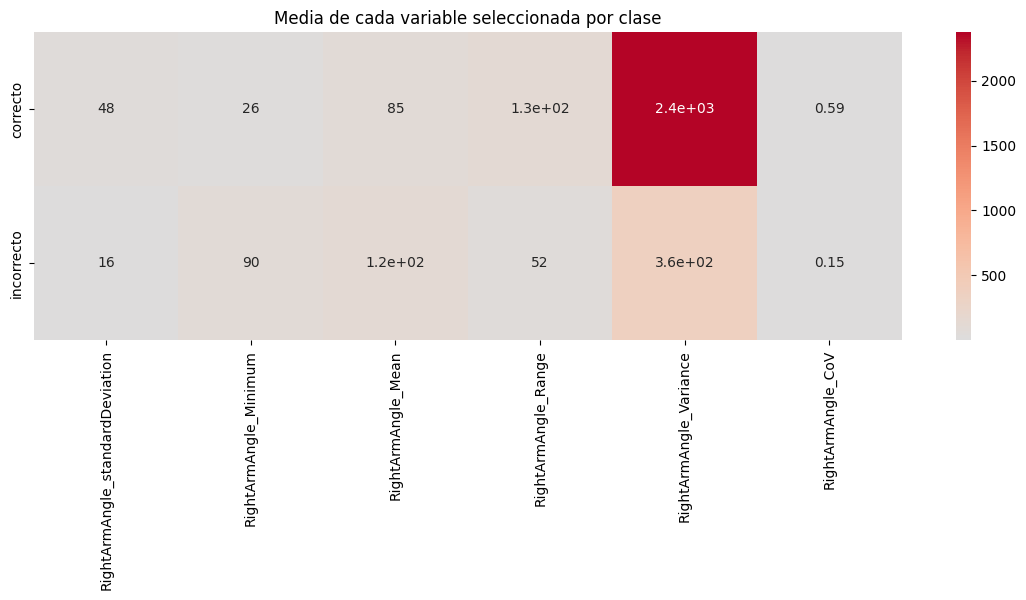

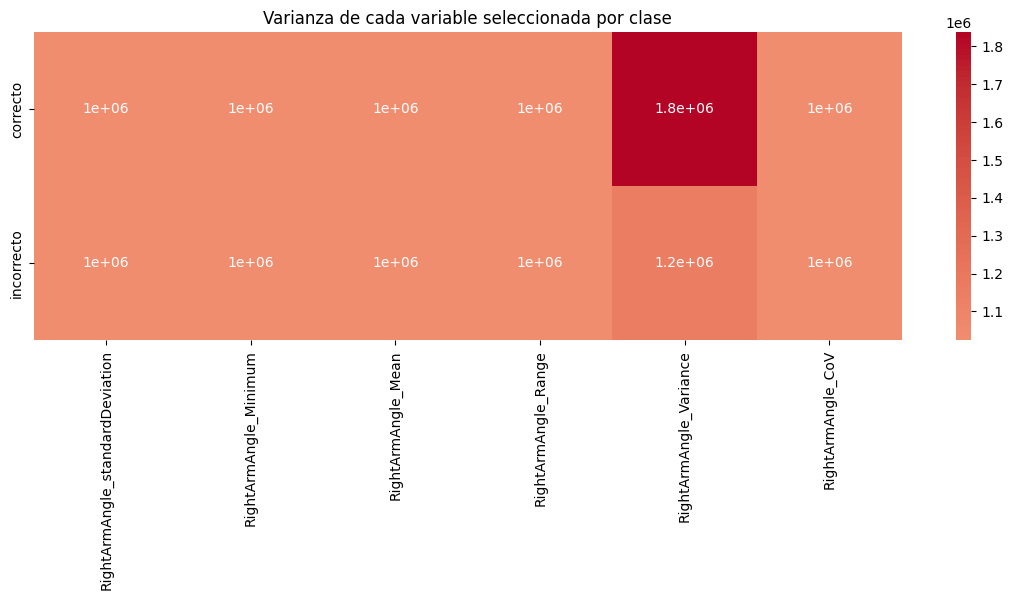

Variables seleccionadas para el gesto SFR


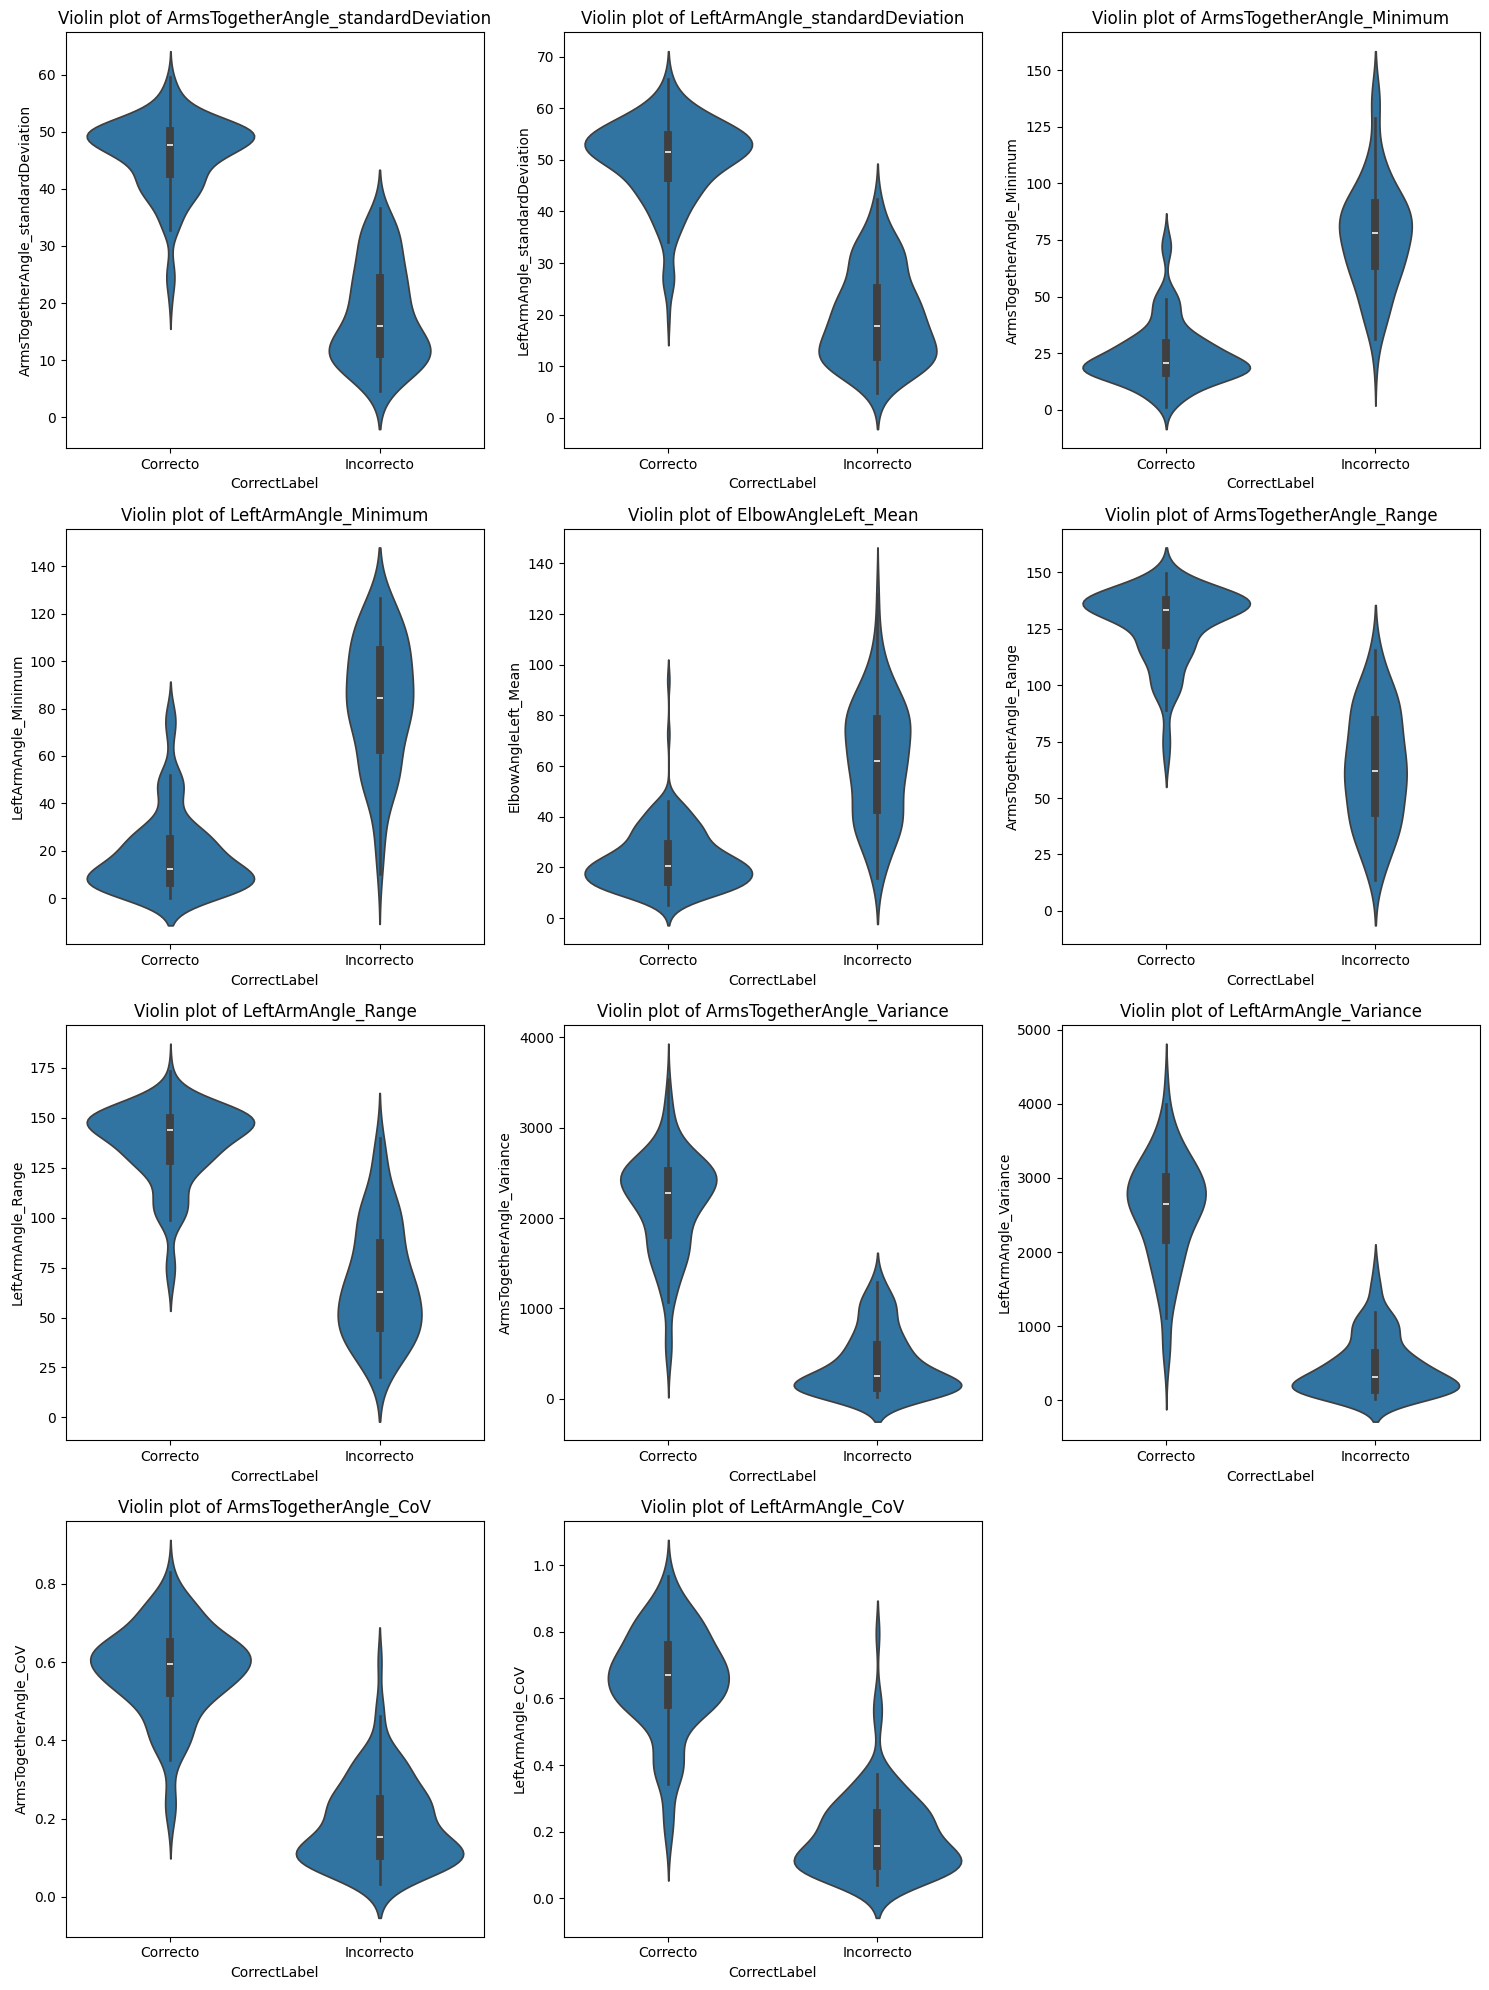

Se ha usado un GaussianNB


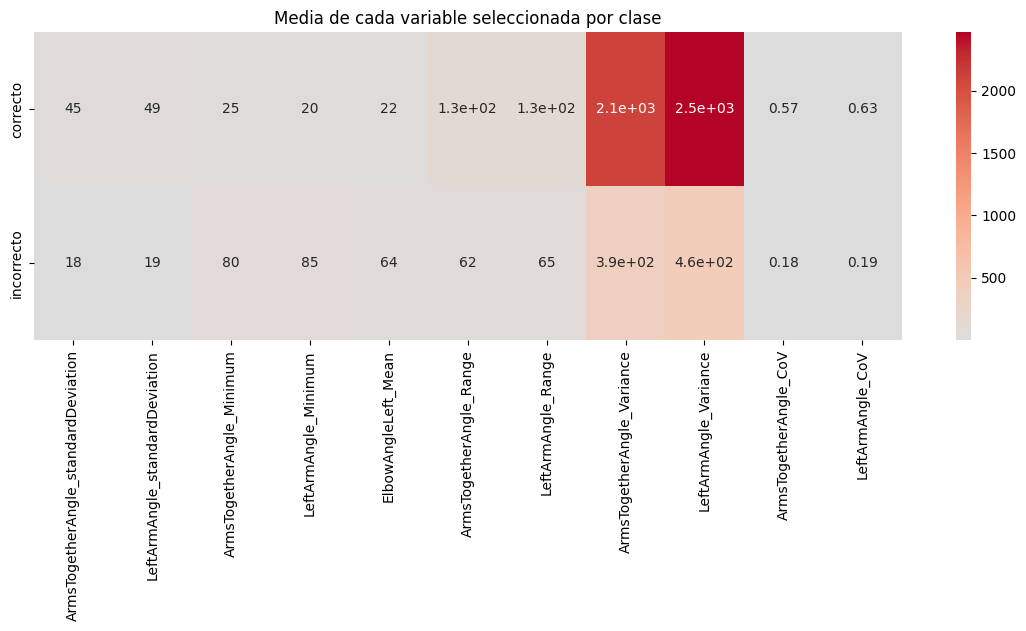

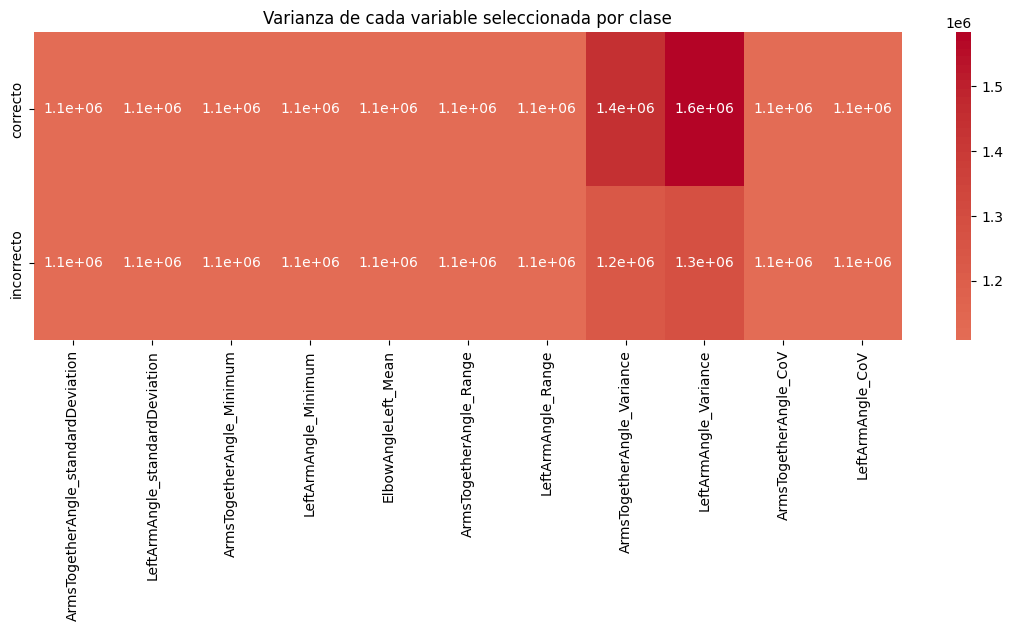

Variables seleccionadas para el gesto SAL


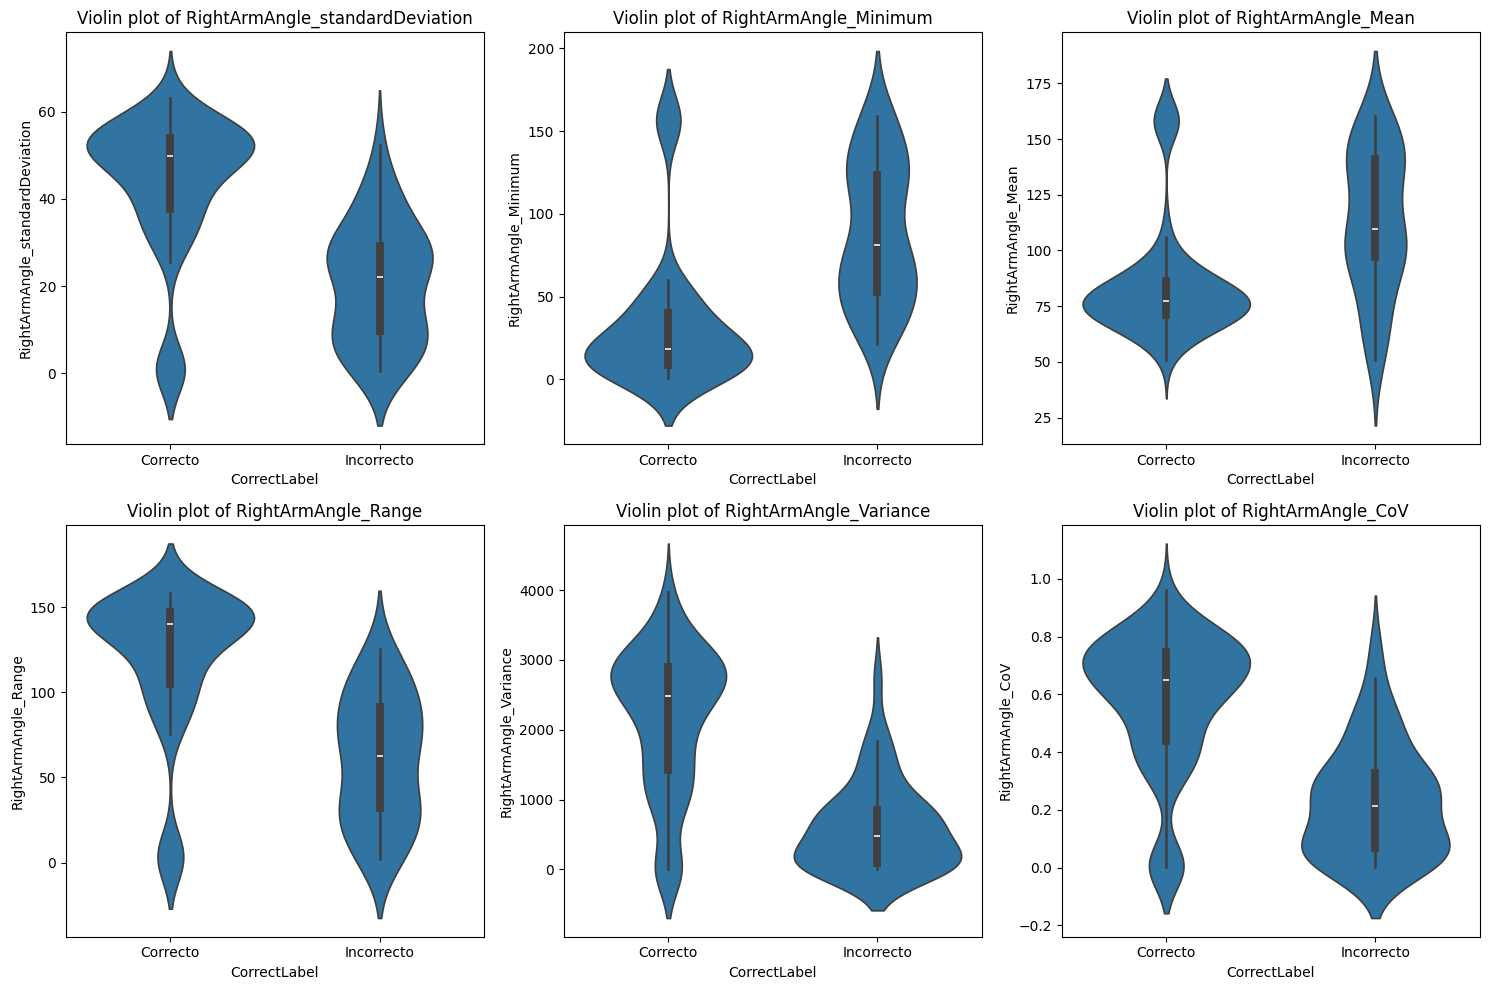

Se ha usado un GaussianNB


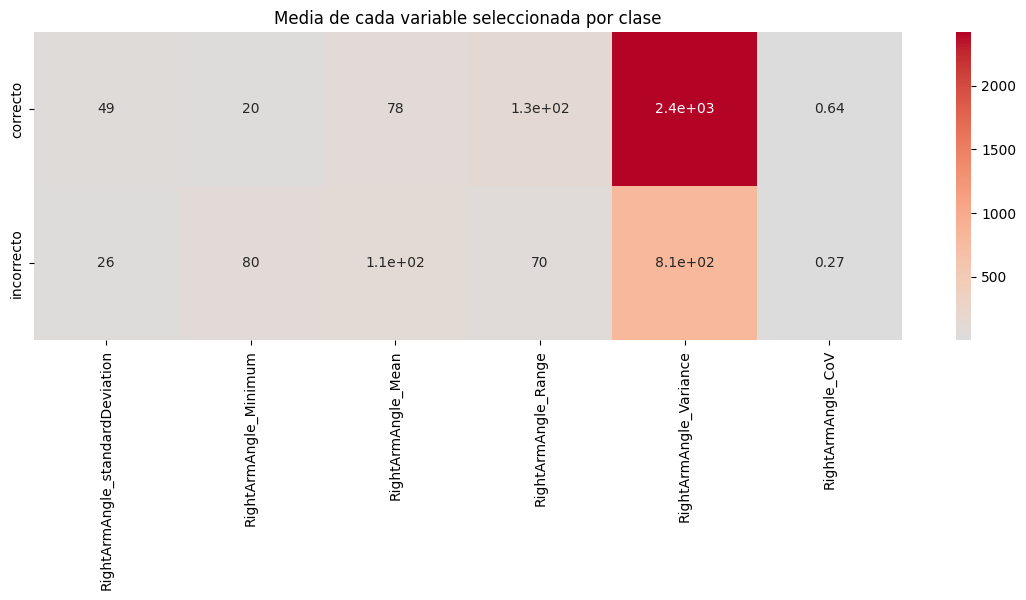

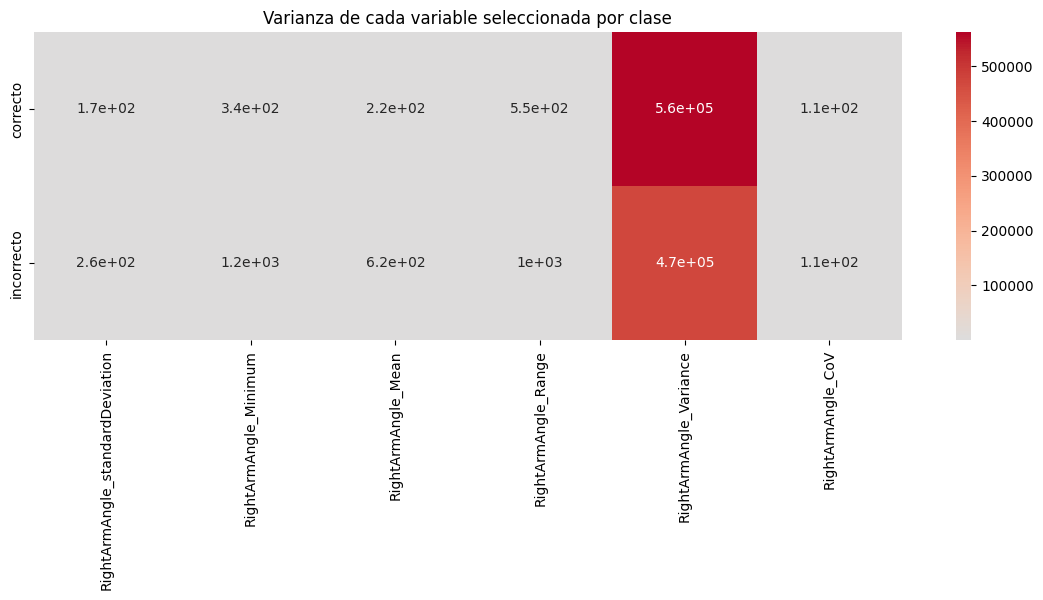

Variables seleccionadas para el gesto SAR


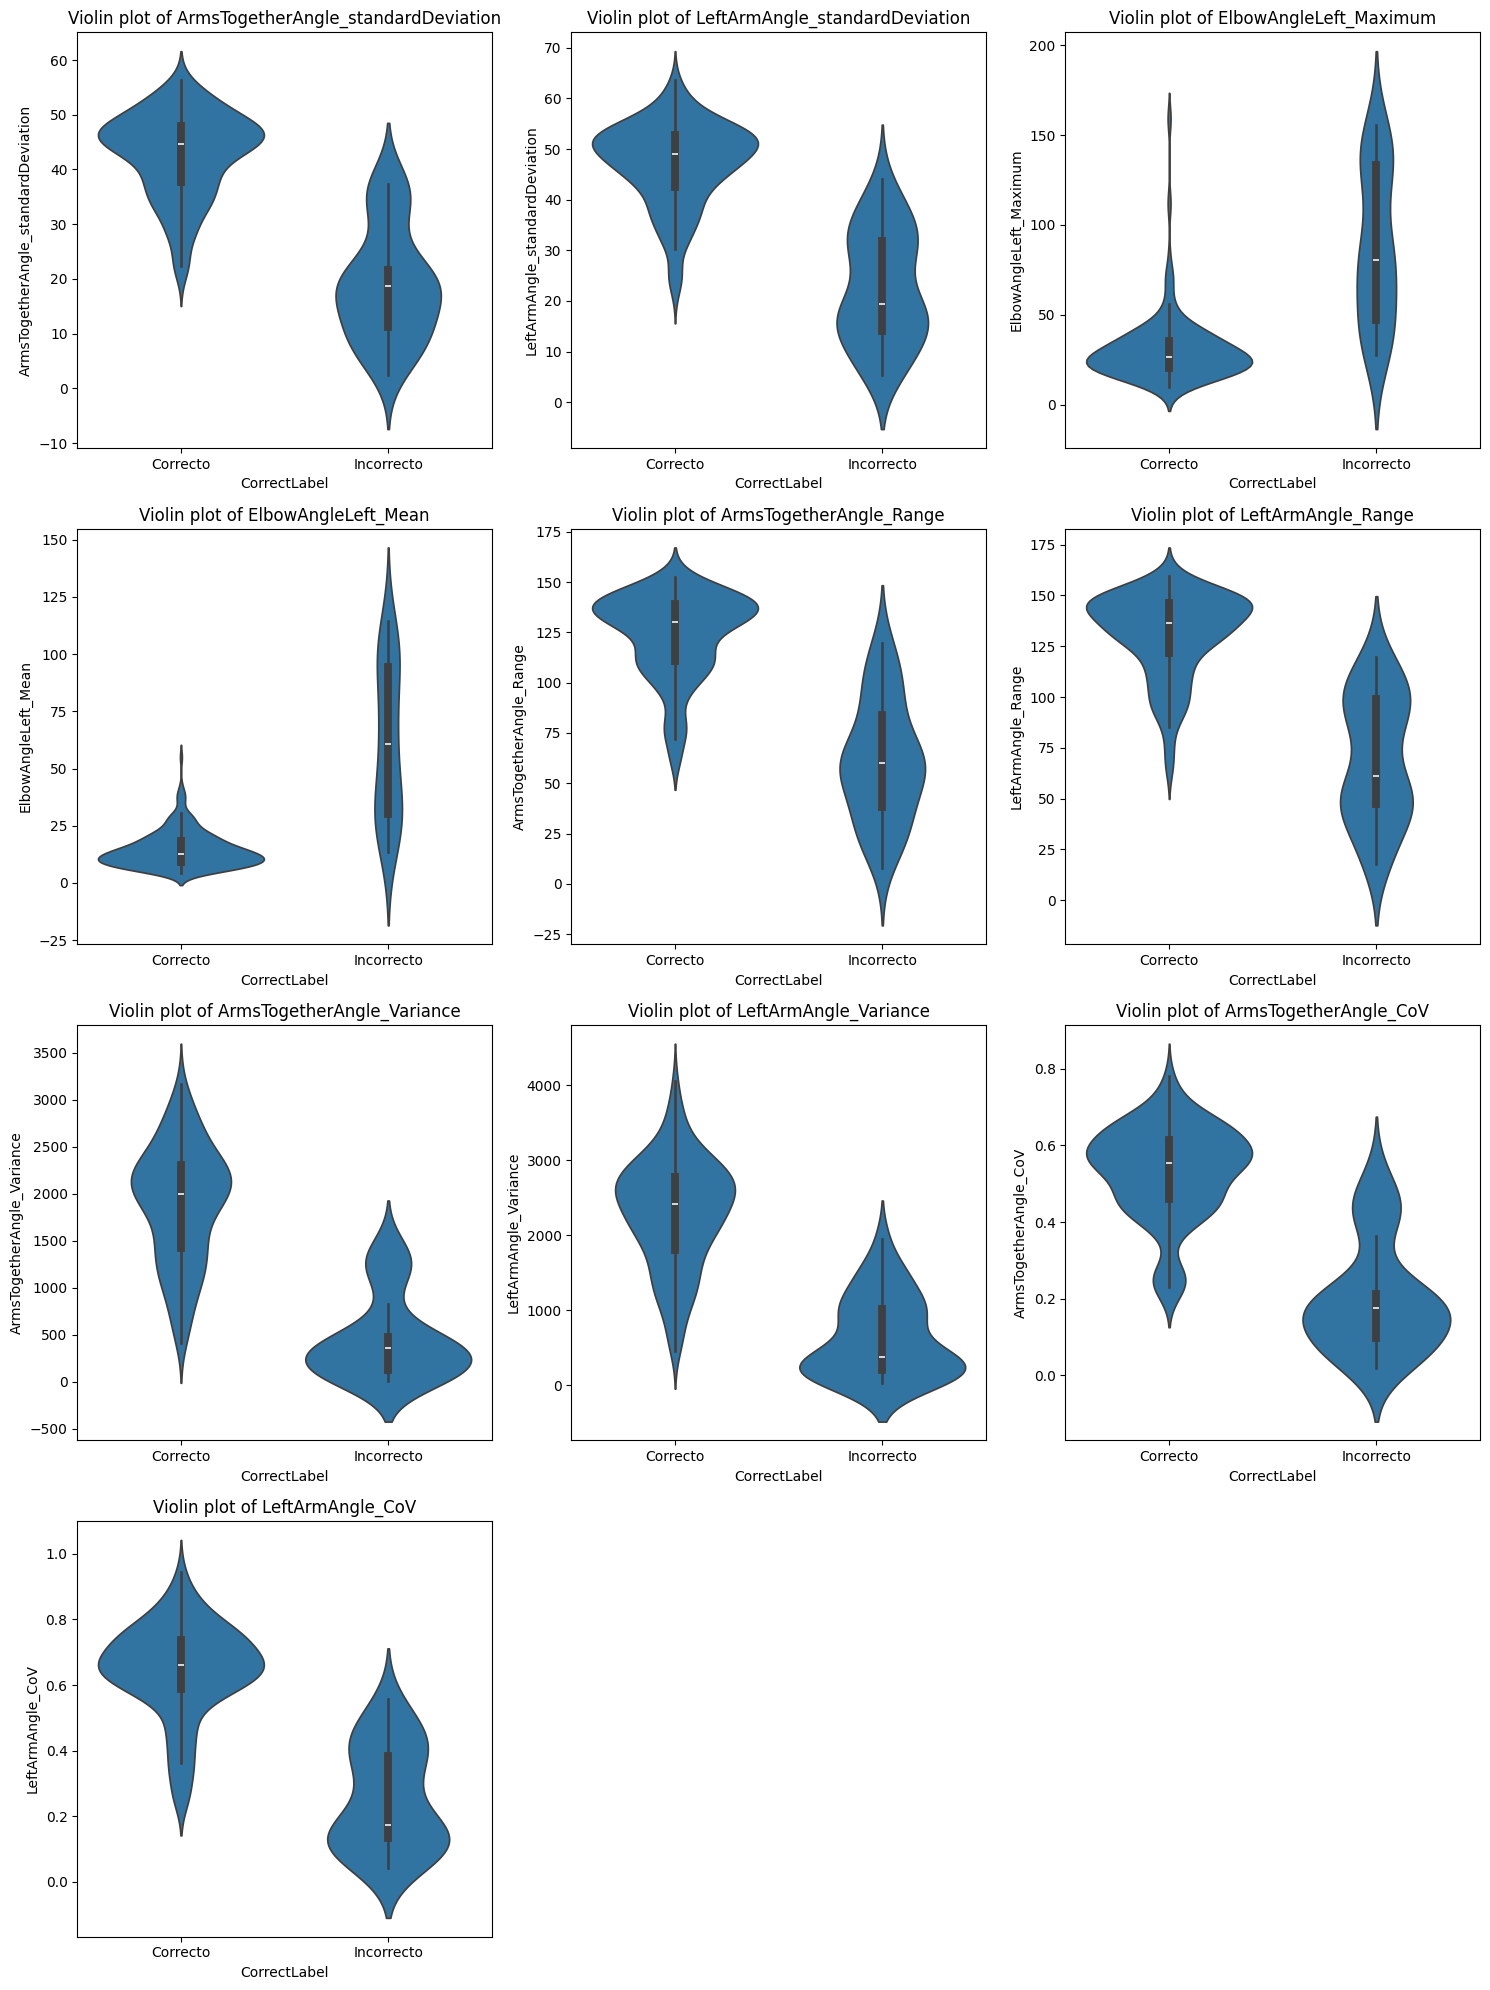

Se ha usado un GaussianNB


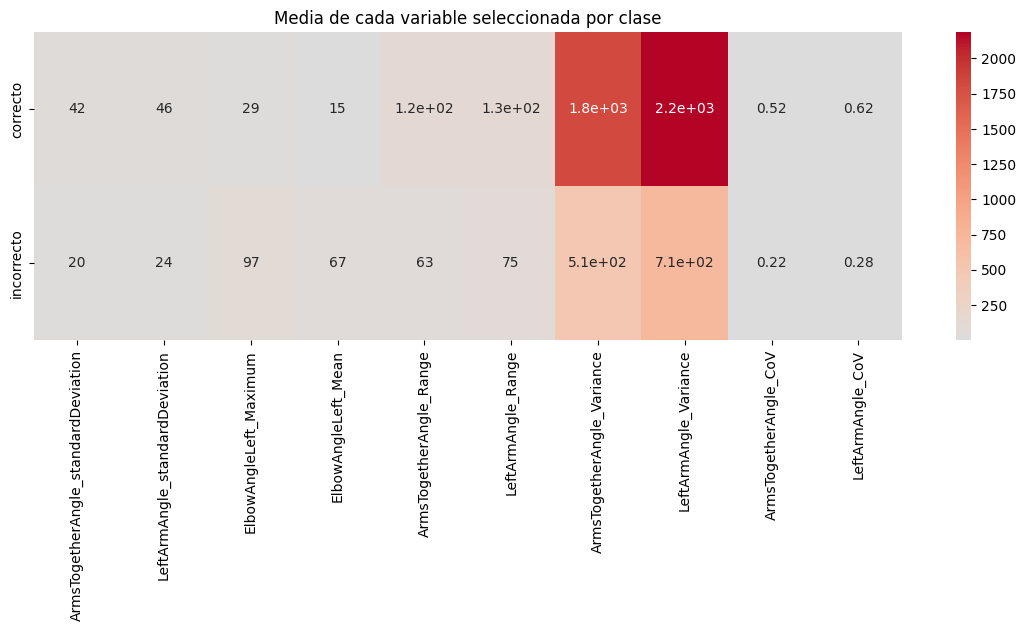

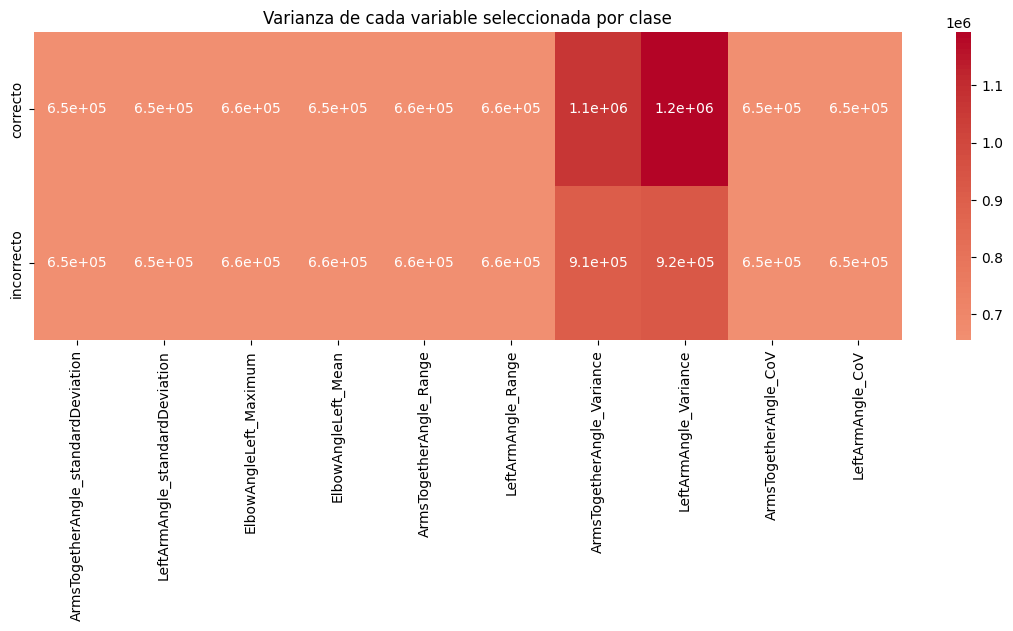

Variables seleccionadas para el gesto SFE


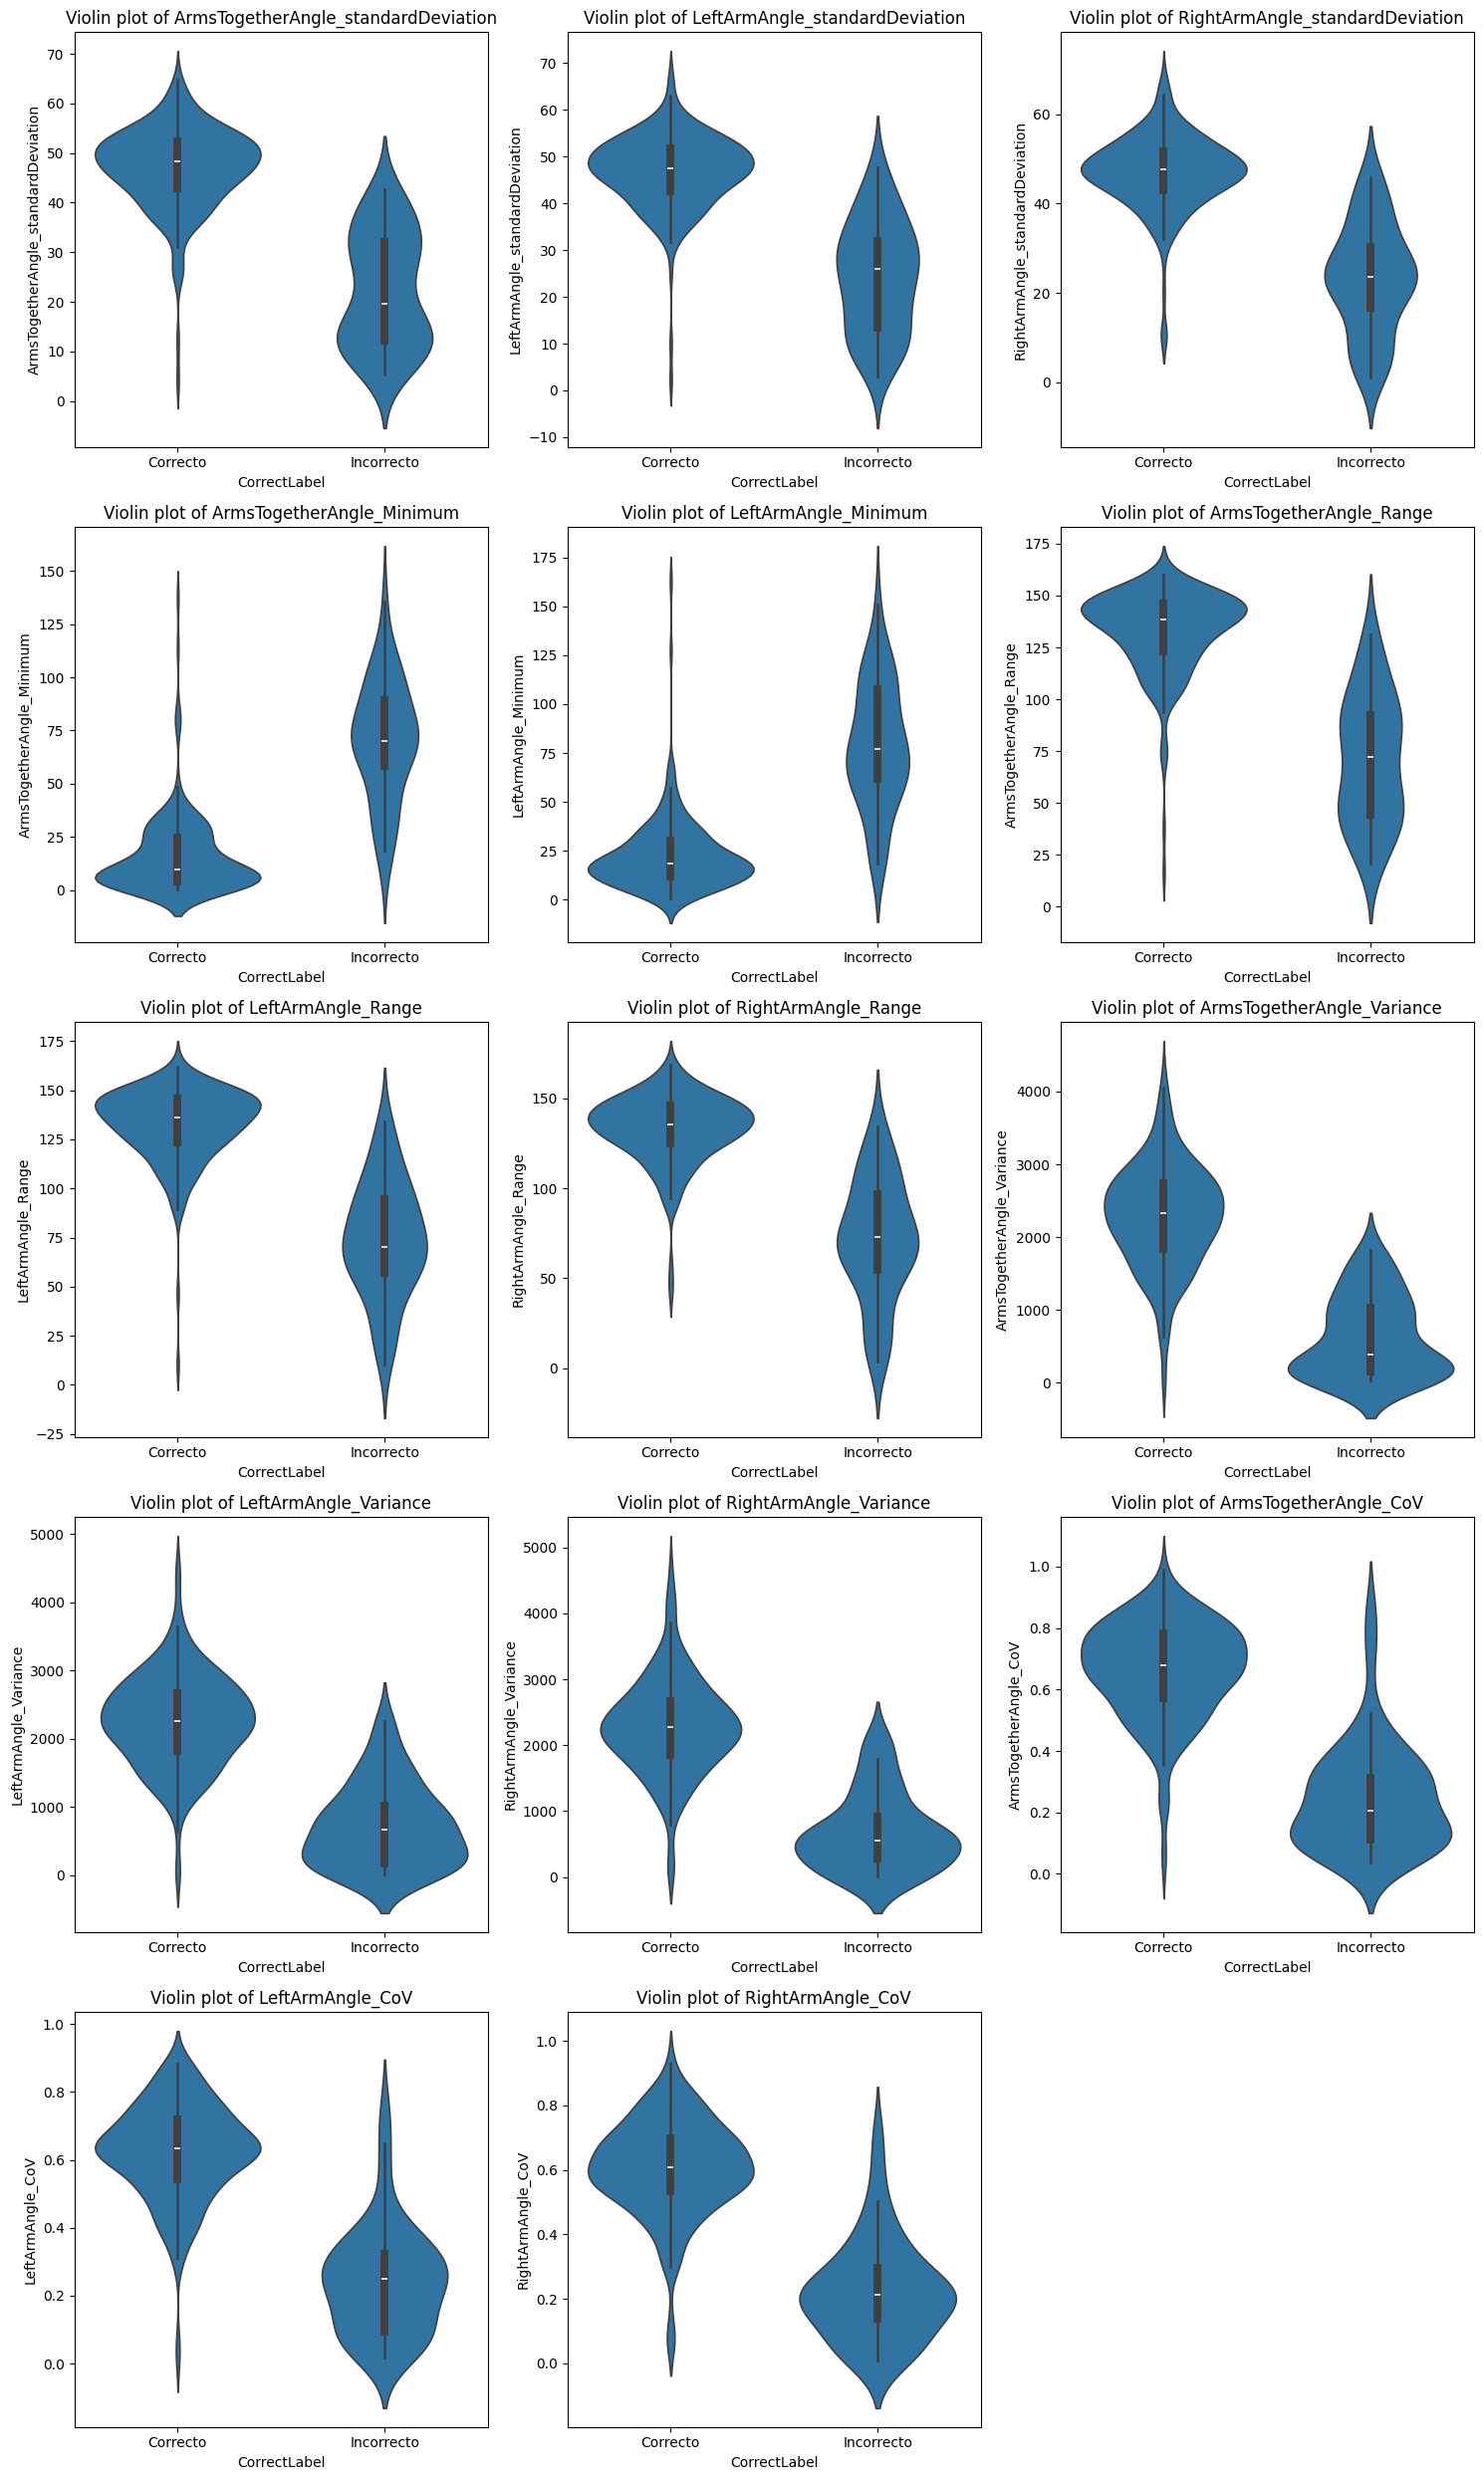

Se ha usado un KNeighborsClassifier
Variables seleccionadas para el gesto STL


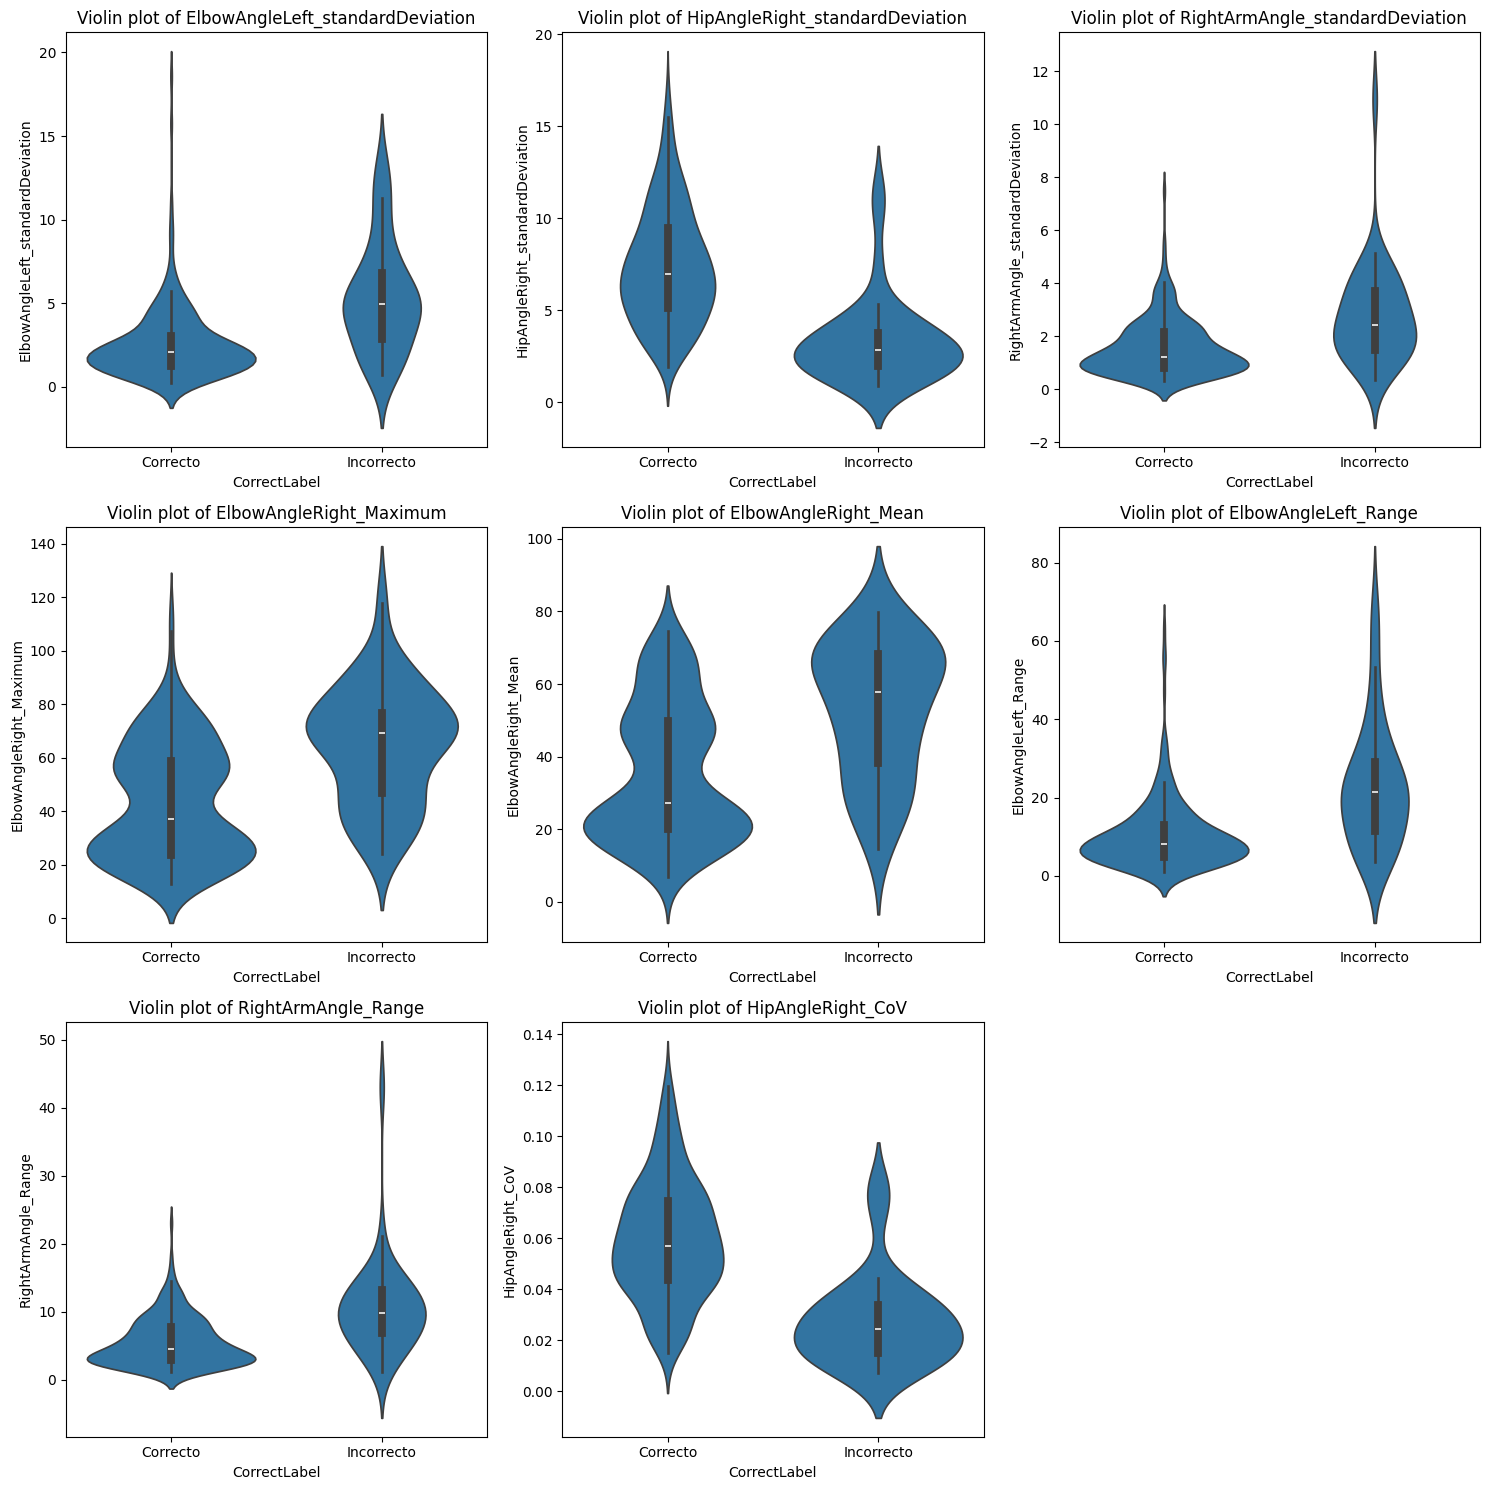

Se ha usado un GaussianNB


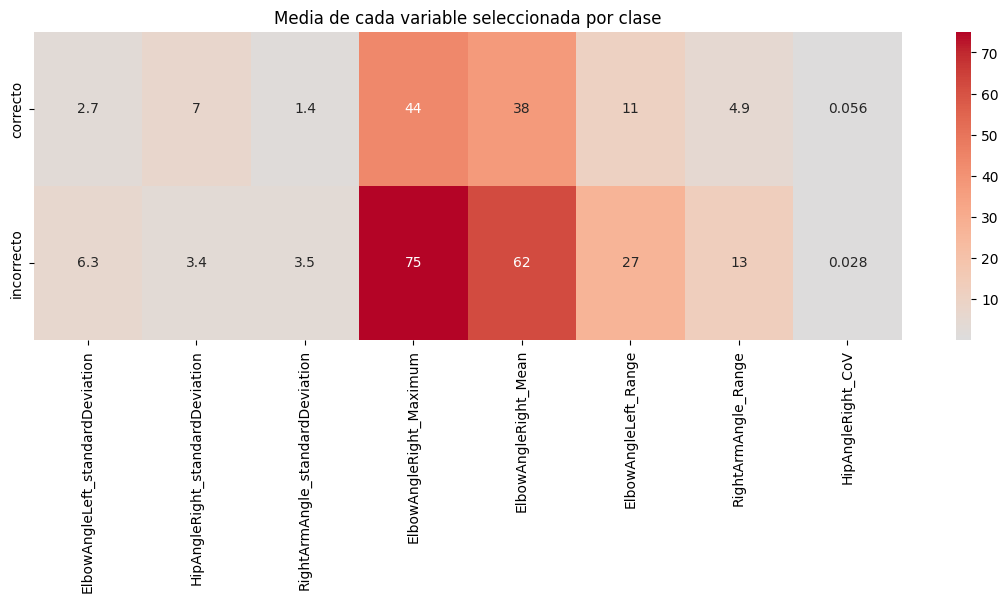

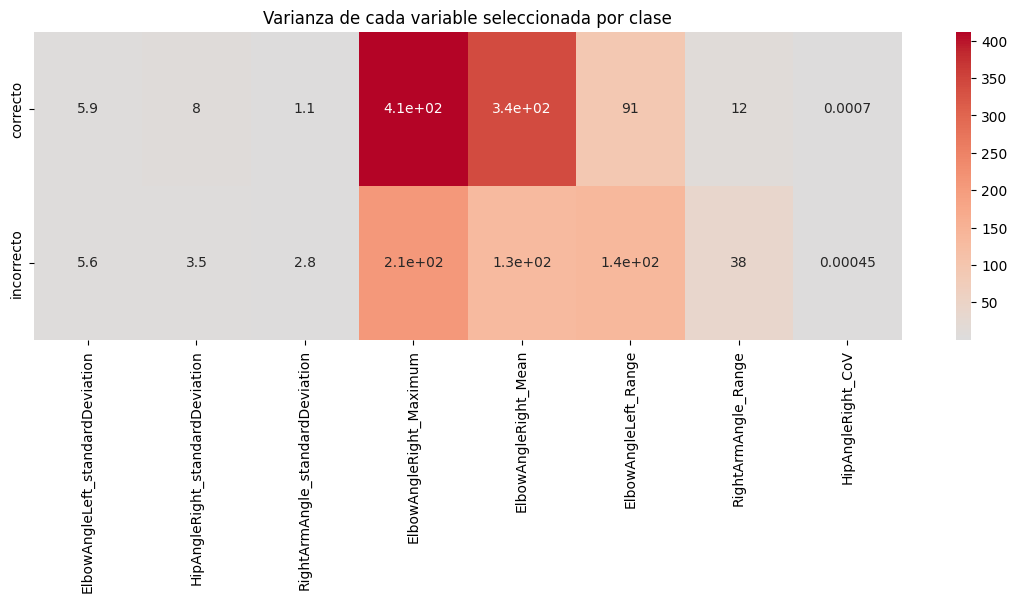

Variables seleccionadas para el gesto STR


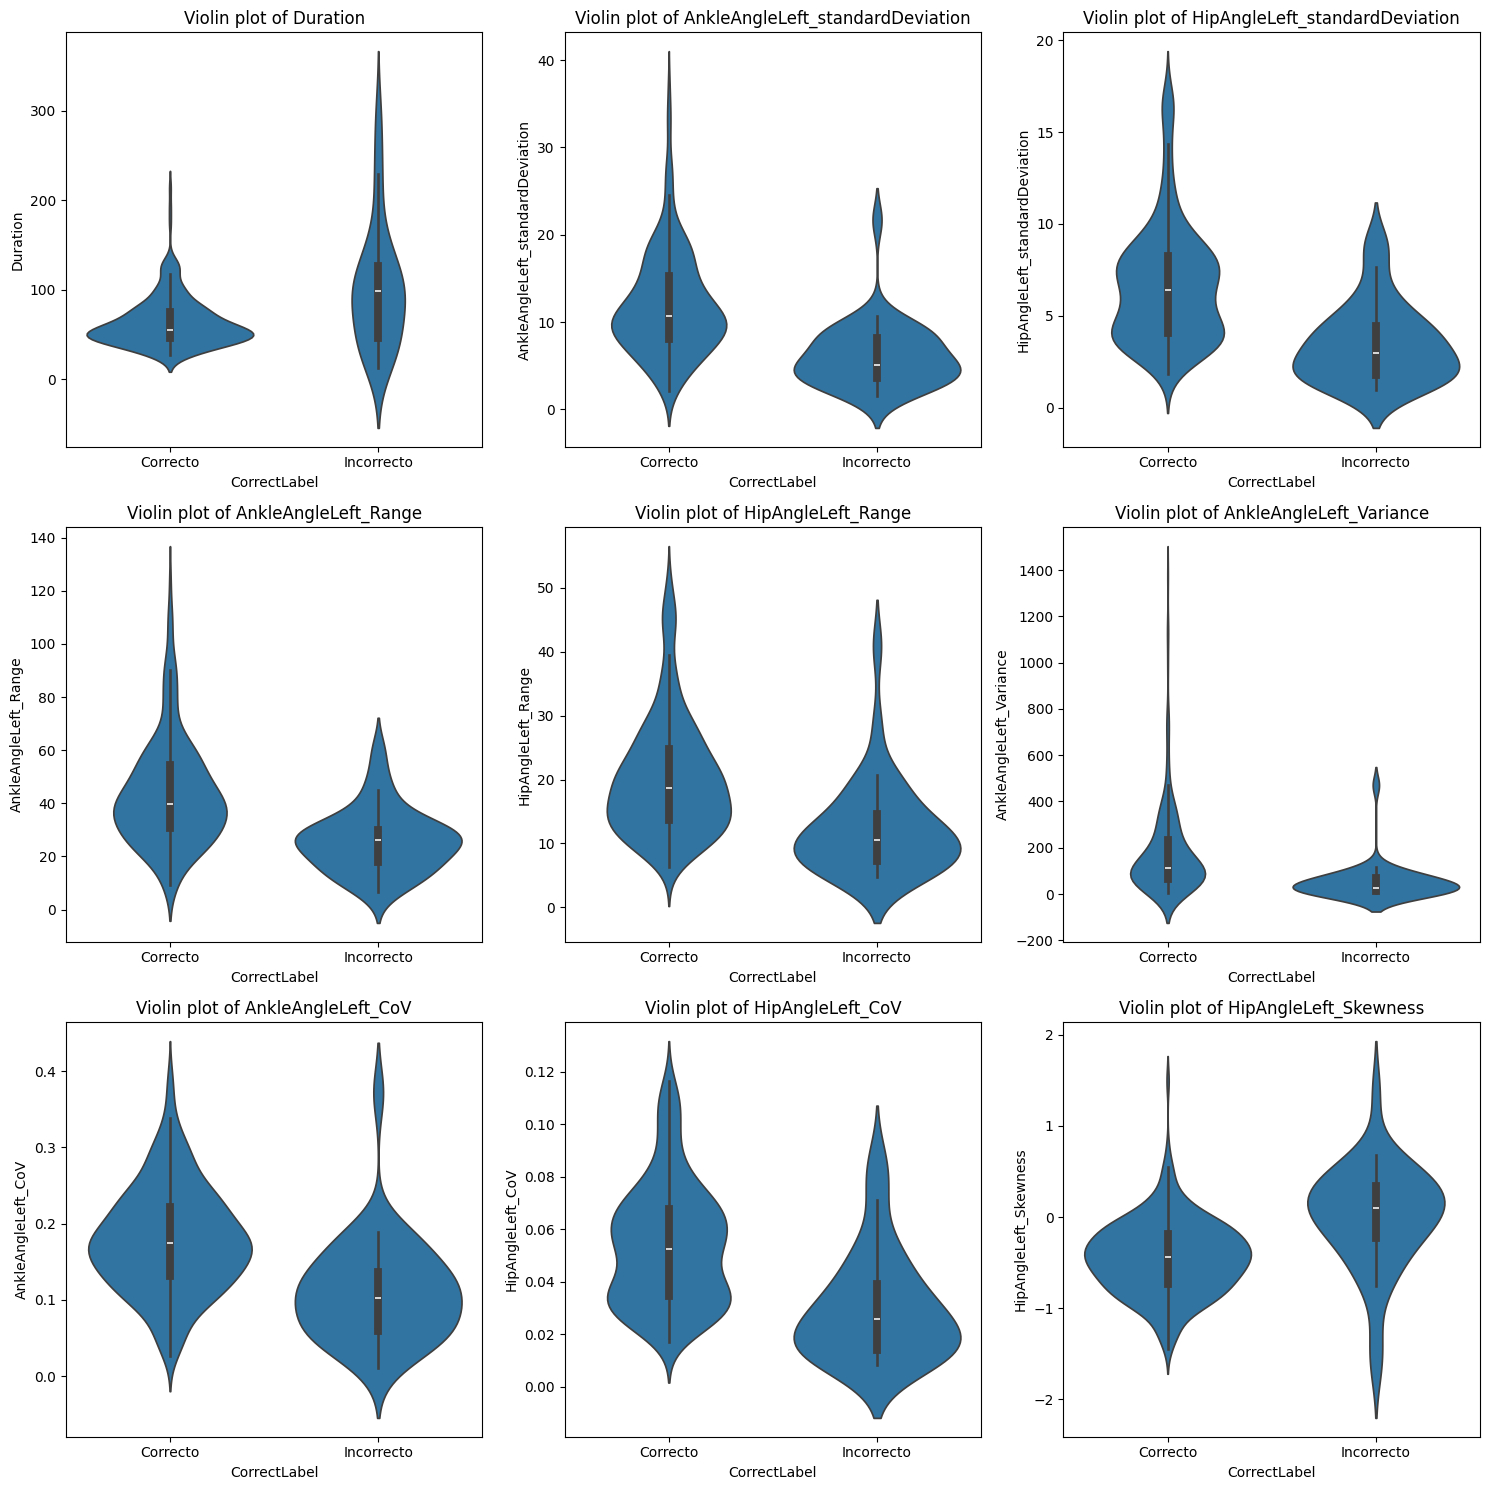

Se ha usado un KNeighborsClassifier


In [36]:
gestures = df['GestureName'].unique()

for gesture in gestures:
    df_gesture = df[df['GestureName'] == gesture]
    y = df_gesture['CorrectLabel']
    y_mapped = y.map({1: 'Correcto', 2: 'Incorrecto'})

    modelo_gesto_path = f'../Resultados/modelo_{gesture}.sav'
    best_pipeline, expected_columns = joblib.load(modelo_gesto_path)

    print(f'Variables seleccionadas para el gesto {gesture}')

    # Variables seleccionadas
    preprocessor = best_pipeline.named_steps['preprocessing']
    feature_names = preprocessor.get_feature_names_out()

    select_kbest = best_pipeline.named_steps['select_features']

    selected_features_mask = select_kbest.get_support()
    selected_features = feature_names[selected_features_mask]

    # Clean feature names
    selected_features = [name.replace('remainder__', '') for name in selected_features]
    selected_features = [name.replace('encoder__', '') for name in selected_features]

    # Create a DataFrame with the selected features
    df_selected = df_gesture[selected_features]

    # Violin plots
    n_features = len(selected_features)
    n_cols = 3  
    n_rows = (n_features + n_cols - 1) // n_cols 
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()

    for i, feature in enumerate(selected_features):
        sns.violinplot(x=y_mapped, y=df_selected[feature], ax=axes[i])
        axes[i].set_title(f'Violin plot of {feature}') 
        axes[i].set_xlabel('CorrectLabel')
        axes[i].set_ylabel(feature)
        

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show() 

    # Visualizar los clasificadores
    classifier = best_pipeline.named_steps['classifier']
    classifier_name = classifier.__class__.__name__
    print(f'Se ha usado un {classifier_name}')

    if classifier_name == 'GaussianNB':

        mean_df = pd.DataFrame(classifier.theta_, columns=selected_features, index=['correcto', 'incorrecto'])
        plt.figure(figsize=(14, 4))
        sns.heatmap(mean_df, annot=True, cmap="coolwarm", center=0)
        plt.title('Media de cada variable seleccionada por clase')
        plt.show()

        variance_df = pd.DataFrame(classifier.var_, columns=selected_features, index=['correcto', 'incorrecto'])
        plt.figure(figsize=(14, 4))
        sns.heatmap(variance_df, annot=True, cmap="coolwarm", center=0)
        plt.title('Varianza de cada variable seleccionada por clase')
        plt.show()
        
    elif classifier_name == 'DecisionTreeClassifier':
        fig = plt.figure(figsize=(8, 6), dpi=300) 
        tree.plot_tree(classifier,
                        feature_names=selected_features,
                        class_names=np.unique(y_mapped.values).astype(str),
                        filled=True)

    elif classifier_name == 'LogisticRegression':
        coefficients = classifier.coef_[0]
      
        plt.figure(figsize=(10, 6))
        plt.barh(selected_features, coefficients)
        plt.xlabel("Valor del coeficiente")
        plt.title("Importancia de las características en la regresión logística")
        plt.axvline(x=0, color="grey", linestyle="--")
        plt.show()

    elif classifier_name == 'RandomForestClassifier':
        fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,2), dpi=900)
        for index in range(0, 5):
            tree.plot_tree(classifier.estimators_[index],
                        feature_names=selected_features, 
                        class_names=np.unique(y_mapped.values).astype(str),
                        filled = True,
                        ax = axes[index])
        axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
        plt.tight_layout()
        plt.show()